# Lab 9 - Graph Data Analytics

Complete the code with TODO tag.

## 4. Graph Modularity and Louvain Algorithm (OPTIONAL)
### 4.1. Compute Modularity

In this exercise, we compute the modularity measure of a graph. First we create a small dataset and manually assign the community label to each node.

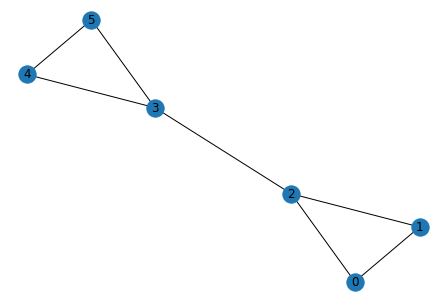

In [1]:
from __future__ import print_function, division
%matplotlib inline

import networkx as nx
import numpy as np

M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw(G, with_labels=True)

In [2]:
for node in [0,1,2]:
    G.nodes[node]['community'] = 0
for node in [3,4,5]:
    G.nodes[node]['community'] = 1

len(G.edges)

7

Now we compute the modularity of the graph given the current community assignment

In [3]:
def compute_modularity(G):
    '''
    TODO: compute the modularity of a networkx graph
    HINTS:
    + The community label of a node can be accessed by G[node_id]['community'] 
    + The degree of a node: G.degree[node_id]
    + The neighbors of a node: G.neighbors(node_id)
    + Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
    '''
    m = len(G.edges)
    Q = 0
    for node_i in G.nodes:
        for node_j in G.nodes:
            if G.nodes[node_i]['community'] == G.nodes[node_j]['community']:
                Q += G.number_of_edges(node_i, node_j) - G.degree[node_i] * G.degree[node_j]/(2*m)
    return Q/(2*m)

compute_modularity(G)

0.0

### 4.2. Naive Louvain algorithm

It is convenient to use the adjacency matrix representation.

In [4]:
def adj_matrix(G):
    M = nx.adjacency_matrix(G)
    M = np.array(M.todense())
    return M
M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = [sum(np.array(row).flatten()) for row in M]
m = sum(k) / 2 #undirected graph
print(M)
print(p)
print(k)
print(m)

[[0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]
[0 1 2 3 4 5]
[2, 2, 3, 3, 2, 2]
7.0


Now we implement phase 1 of Louvain algorithm, in which we partition the nodes to maximize the modularity

In [10]:
def phase1(M, p=None, k=None):
    N = len(M)
    
    # Community label
    if p is None: p = np.array([i for i in range(N)])
    
    #Node degree
    if k is None: k = np.array([sum(row) for row in M])
    
    m = sum(k) / 2

    # Main algorihtm (phase 1)
    improvement = True
    while improvement:
        improvement = False
        for i in range(N):
            p_max = p[i]
            delta_Q_max = 0
            for j in range(N):
                if M[i][j] == 0: continue
                Q_plus = 0 # compute Q_plus = join i to the community of j 
                Q_minus = 0 # compute Q_minus = remove i out of its current community
                
                # TODO: Compute the modularity gain via Q_plus and Q_minus
                for x in range(N):
                    if x != i and p[x] == p[j]:
                        Q_plus += M[i][x] - k[i] * k[x] / (2*m)
                    
                    if x != i and p[x] == p[i]:
                        Q_minus += M[i][x] - k[i] * k[x] / (2*m)
                
                if delta_Q_max < Q_plus - Q_minus:
                    delta_Q_max = Q_plus - Q_minus
                    p_max = p[j]
            #Choose the best modularity gain
            p[i] = p_max

            # Track improvement
            if not improvement and delta_Q_max > 0:
                improvement = True
    return(p)

phase1(M)

array([1, 1, 1, 5, 5, 5])

Now we implement the phase 2 of Louvain algorithm, in which we merge the nodes within the same community to a single node and create edges between communities.

In [6]:
def phase2(M, p):
    N = len(M)
    communities = np.unique(p)
    C = len(communities)
    communities = dict(zip(communities, range(len(communities))))
    
    M_new = np.array([[0] * C for x in communities])
    
    # TODO: create an edge between two communities 
    # if there is an edge between one node of source community and one node of target community
    for i in range(N):
        for j in range(N):
            if M[i][j] != 0 and p[i] != p[j]:
                M_new[communities[p[i]]][communities[p[j]]] = 1
    return M_new

M_new = phase2(M, phase1(M))
p_new = phase1(M_new)
M_new, p_new

(array([[0, 1],
        [1, 0]]),
 array([1, 1]))

Now we can implement the full Louvain algorithm

In [7]:
def louvain(M, verbose=True):
    C = len(M)
    iter = 0
    M_new = M
    print("Level 0 partition: {0}".format(np.array([i for i in range(C)])))
    while C > 1:
        iter += 1
        p = phase1(M_new)
        M_new = phase2(M_new, p)
        C = len(M_new)
        print("Level {0} partition: {1}".format(iter, p))
        
louvain(M)

Level 0 partition: [0 1 2 3 4 5]
Level 1 partition: [1 1 1 5 5 5]
Level 2 partition: [1 1]


### 4.3. Efficient Louvain algorithm

The naive Louvain algorithm is not efficient. It takes $O(n^3)$. There are some improvements in the literature

+ http://www.ijcee.org/vol8/927-A023.pdf
+ https://www.cs.upc.edu/~CSN/slides/07communities.pdf
+ https://en.wikipedia.org/wiki/Louvain_Modularity
+ https://www.quora.com/Is-there-a-simple-explanation-of-the-Louvain-Method-of-community-detection
+ http://arxiv.org/abs/0803.0476
+ https://stackoverflow.com/questions/22070196/community-detection-in-networkx

For simplicity, we will demo one existing implementation. You can try to improve the final visualization further.

```bash
conda install python-louvain
```

In [11]:
!pip install python-louvain

     ------------------------------------ 204.6/204.6 kB 830.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9398 sha256=63f846f2977c134e0a59e43827e16da64f31c12ba94d2861735b6bcb6f0d8c0d
  Stored in directory: c:\users\ben\appdata\local\pip\cache\wheels\af\40\91\ef3635f7d3ddbd889b5af9f1ac22b8d30c48d6f744cd74a6d1
Successfully built python-louvain


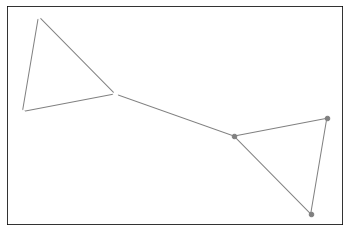

In [12]:
import community

# TODO: Compute the partition of current graph with maximal modularity using python-louvain library
partition = community.best_partition(G)

def visualize(G, partition):
    import matplotlib.pyplot as plt
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count += 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()
    return

visualize(G, partition)

### 4.4. Efficiency comparison

We load a larger network and compare the running time of the two implementations.

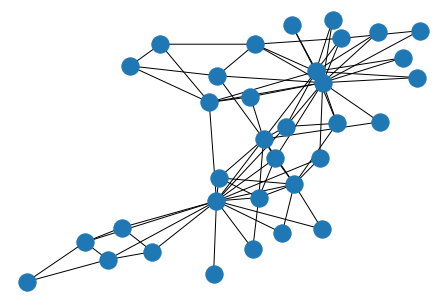

In [13]:
G = nx.karate_club_graph()
nx.draw(G)

In [14]:
import time
M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = np.array([sum(row) for row in M])

start_time = time.time()
p = phase1(M, p, k)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)

--- 0.07897520065307617 seconds ---
[17 17 12 12 10 16 16 12 32 12 10 17 12 12 32 32 16 17 32 17 32 17 32 25
 25 25 32 25 25 32 32 25 32 32]


--- 0.0039980411529541016 seconds ---
{0: 0, 1: 0, 2: 0, 3: 0, 4: 3, 5: 3, 6: 3, 7: 0, 8: 1, 9: 0, 10: 3, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 3, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 2, 25: 2, 26: 1, 27: 1, 28: 2, 29: 1, 30: 1, 31: 2, 32: 1, 33: 1}


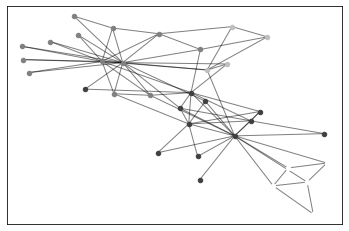

In [15]:
start_time = time.time()
p = community.best_partition(G)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)
visualize(G, p)

Now we load an even larger network: https://snap.stanford.edu/data/email-Eu-core.html

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


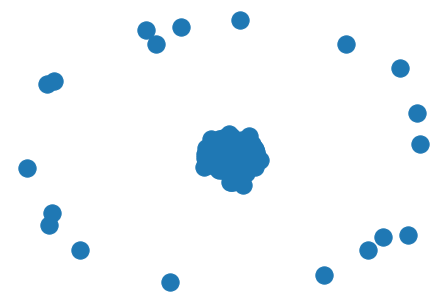

In [16]:
G = nx.read_edgelist("email-Eu-core.txt")
nx.draw(G)
print(nx.info(G))

--- 0.7247674465179443 seconds ---


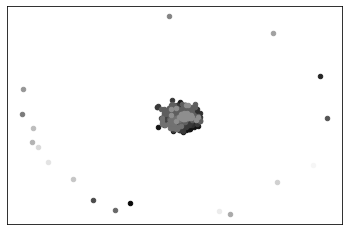

In [17]:
start_time = time.time()
p = community.best_partition(G)
print("--- %s seconds ---" % (time.time() - start_time))
# print(p)
visualize(G, p)

In [19]:
#Beware, this will take a long time
M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = np.array([sum(row) for row in M])

start_time = time.time()
p = phase1(M, p, k)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)

--- 603.7120876312256 seconds ---
[ 797  797 1001 ...  797  477 1001]
